## Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
sns.set_theme()

In [2]:
df = pd.read_csv("uber.csv")

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## Pre-processing 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [5]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [6]:
df.drop(['Unnamed: 0', 'key'], axis=1, inplace = True)

In [7]:
df.dropna(axis=0, inplace = True)

In [8]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## Feature Engineering

In [10]:
def Date_conversion(df):
    year = pd.to_datetime(df).year
    month =  pd.to_datetime(df).month
    day =  pd.to_datetime(df).dayofweek
    minute =  pd.to_datetime(df).minute
    hour = pd.to_datetime(df).hour
    return year,month,day,minute,hour

In [11]:
pd.to_datetime(df['pickup_datetime']).dt.year

0         2015
1         2009
2         2009
3         2009
4         2014
          ... 
199995    2012
199996    2014
199997    2009
199998    2015
199999    2010
Name: pickup_datetime, Length: 199999, dtype: int32

In [12]:
df['year'] = Date_conversion(df['pickup_datetime'].to_numpy())[0]
df['month'] = Date_conversion(df['pickup_datetime'].to_numpy())[1]
df['day'] = Date_conversion(df['pickup_datetime'].to_numpy())[2]
df['minute'] = Date_conversion(df['pickup_datetime'].to_numpy())[3]
df['hour'] = Date_conversion(df['pickup_datetime'].to_numpy())[4]

In [13]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,minute,hour
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,52,19
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,4,20
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,45,21
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,22,8
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,47,17


In [14]:
def distance(lon1, lat1, lon2, lat2):
    dist = []
    for pos in range(len(lon1)):
        long1,lati1,long2,lati2 = map(math.radians,[lon1[pos],lat1[pos],lon2[pos],lat2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = math.sin(dist_lati/2)**2 + math.cos(lati1) * math.cos(lati2) * math.sin(dist_long/2)**2
        c = 2 * math.asin(math.sqrt(a))*6371
        dist.append(c)
    return dist

In [15]:
df['distance_km'] = distance(df['pickup_longitude'].to_numpy(), 
                                       df['pickup_latitude'].to_numpy(), 
                                       df['dropoff_longitude'].to_numpy(), 
                                       df['dropoff_latitude'].to_numpy())

In [16]:
df.drop(['pickup_datetime','pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace = True)

In [17]:
df.head()

,fare_amount,passenger_count,year,month,day,minute,hour,distance_km
0,7.5,1,2015,5,3,52,19,1.683323
1,7.7,1,2009,7,4,4,20,2.457590
2,12.9,1,2009,8,0,45,21,5.036377
3,5.3,3,2009,6,4,22,8,1.661683
4,16.0,5,2014,8,3,47,17,4.475450


## Train-test Split

In [18]:
X= df.drop('fare_amount', axis=1)
y= df['fare_amount']

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                random_state=42)

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(159999, 7) (159999,)
(40000, 7) (40000,)


In [21]:
X_train

,passenger_count,year,month,day,minute,hour,distance_km
157134,1,2012,9,1,12,22,1.949255
116607,1,2011,5,0,50,21,1.813534
78783,3,2012,3,5,56,10,1.295424
103093,2,2010,7,5,10,23,0.375743
162400,5,2009,2,3,32,14,19.947381
...,...,...,...,...,...,...,...
119880,5,2010,6,3,20,20,2.984823
103695,5,2012,2,6,52,2,2.159242
131933,1,2009,11,4,13,4,3.701059
146868,1,2010,8,2,30,9,1.322781


## Creating Pipelines

In [22]:
trf1 = ColumnTransformer([
    ('scale',MinMaxScaler(),[0,6])
])

In [23]:
from sklearn.linear_model import LinearRegression
trf2 = LinearRegression()

In [24]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
])

In [25]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  [0, 6])])),
                ('trf2', LinearRegression())])

In [26]:
y_pred = pipe.predict(X_test)

In [27]:
from sklearn import metrics
# Calculate MAE
lr_MAE= metrics.mean_absolute_error(y_test, y_pred)

# Calculate MSE
lr_MSE= metrics.mean_squared_error(y_test, y_pred)

# Calculate RMSE
lr_RMSE= np.sqrt(lr_MSE)
print('Mean Absolute Error (MAE) for lr model:', lr_MAE)
print('Mean Squared Error (lr_MAE) for lr model:', lr_MSE)
print('Root Mean Absolute Error (lr_RMSE) foor lr model:', lr_RMSE)

Mean Absolute Error (MAE) for lr model: 6.069864829008623
Mean Squared Error (lr_MAE) for lr model: 103.97851143037539
Root Mean Absolute Error (lr_RMSE) foor lr model: 10.196985408951775


In [29]:
from sklearn.ensemble import RandomForestRegressor #library for random forest model
rfrmodel = RandomForestRegressor(n_estimators=100, random_state=101)
rfrmodel.fit(X_train,y_train)

RandomForestRegressor(random_state=101)

In [30]:
rfrmodel_pred= rfrmodel.predict(X_test)
rfrmodel_pred

array([ 6.92  ,  5.28  , 12.42  , ...,  5.652 , 12.58  ,  9.1749])

In [31]:
from sklearn import metrics
# Calculate MAE
rf_MAE= metrics.mean_absolute_error(y_test, rfrmodel_pred)

# Calculate MSE
rf_MSE= metrics.mean_squared_error(y_test, rfrmodel_pred)

# Calculate RMSE
rf_RMSE= np.sqrt(rf_MSE)
print('Mean Absolute Error (MAE) for rf model:', rf_MAE)
print('Mean Squared Error (lr_MAE) for rf model:', rf_MSE)
print('Root Mean Absolute Error (lr_RMSE) foor rf model:', rf_RMSE)

Mean Absolute Error (MAE) for rf model: 2.3981848238095234
Mean Squared Error (lr_MAE) for rf model: 33.1045859365209
Root Mean Absolute Error (lr_RMSE) foor rf model: 5.753658482784749


In [33]:
from sklearn.metrics import r2_score 
lr_r2=r2_score(y_test, y_pred)
lr_r2
rfr_r2=r2_score(y_test, rfrmodel_pred)
rfr_r2

0.6817599120735294

In [82]:
# create the result table for all accuracy scores
# cols = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error']

# creating an empty table to compile results later
# columns: specifies the columns to be selected
result = pd.DataFrame()

linreg_full_metrics = pd.DataFrame([{'Model':"LR", 
                                     'Mean Absolute Error':lr_MAE, 
                                     'Mean Squared Error':lr_MSE, 
                                     'Root Mean Squared Error':lr_RMSE,
                                     'R2 score':  rfr_r2}])

# # adding the lr accuracy scores to the result table by using 'append' method
result=pd.concat([result, linreg_full_metrics],axis=1)
result

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 score
0,LR,6.069865,103.978511,10.196985,0.68176


In [83]:
ranfor_full_metrics = pd.DataFrame([{'Model': "Random Forest ",
                     'Mean Absolute Error':rf_MAE,
                     'Mean Squared Error': rf_MSE,
                     'Root Mean Squared Error': rf_RMSE  ,
                     'R2 score':  rfr_r2
                   }])

#adding the rf accuracy scores to the result table by using 'append' method
result=pd.concat([result, ranfor_full_metrics],ignore_index=True)
result

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 score
0,LR,6.069865,103.978511,10.196985,0.68176
1,Random Forest,2.398185,33.104586,5.753658,0.68176


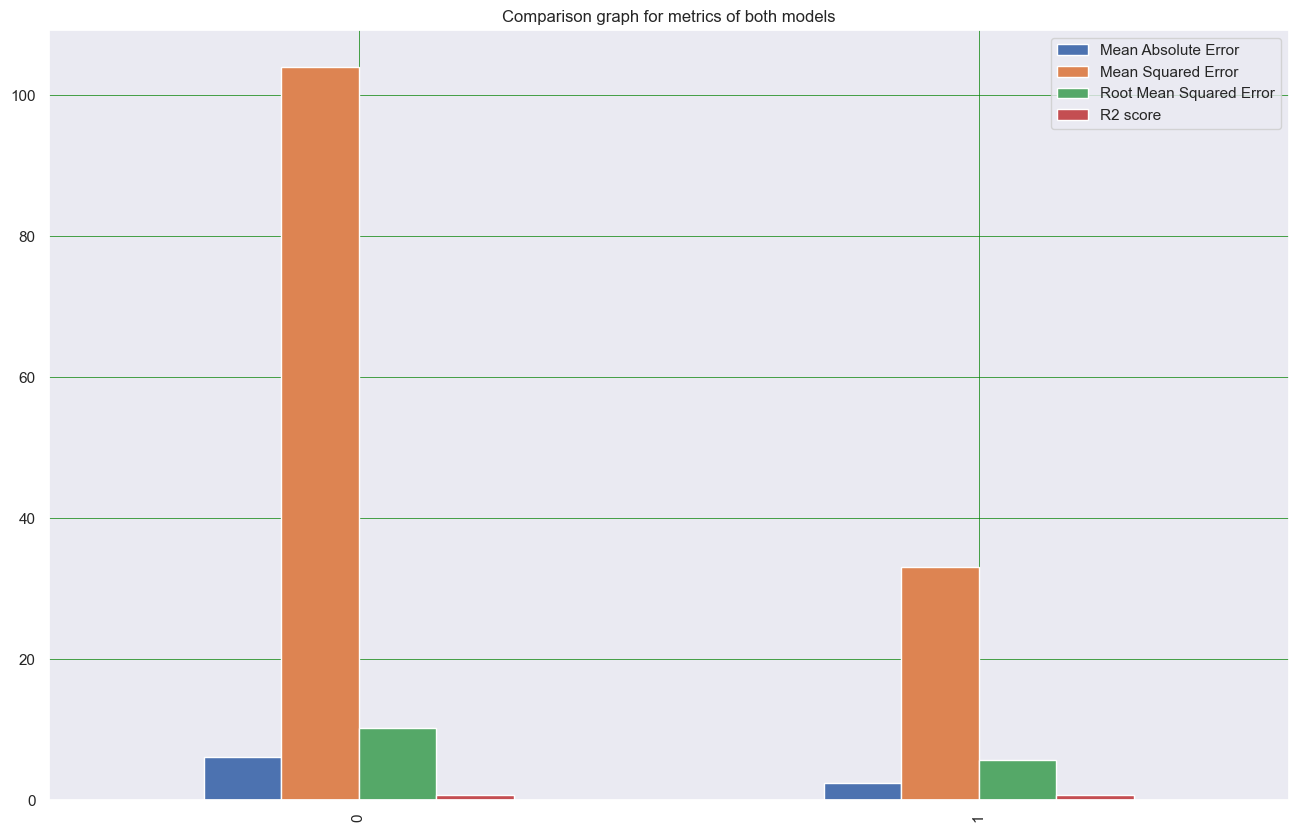

In [84]:
result.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison graph for metrics of both models')
plt.show()

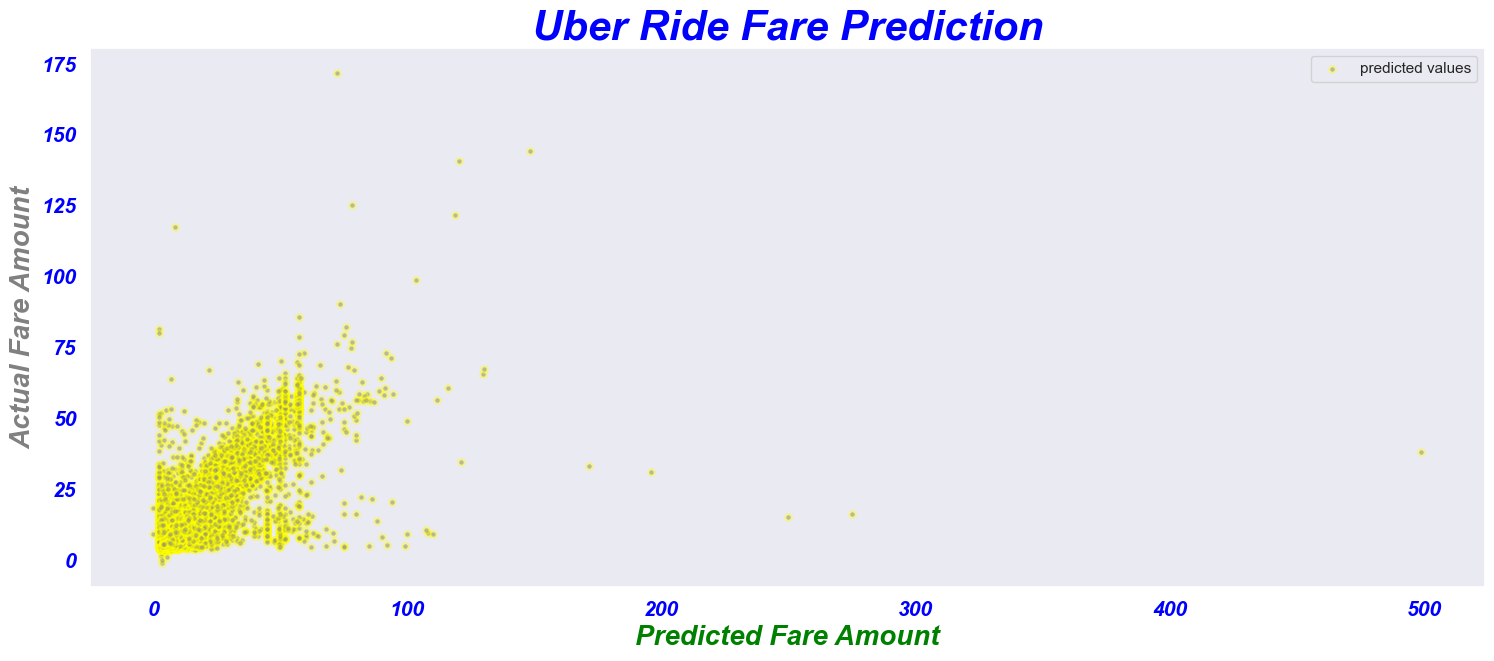

In [88]:
plt.figure(figsize=(18,7))
plt.scatter(y_test, rfrmodel_pred, color='blue', linewidth=3, label='predicted values', alpha=0.4, marker='o', s=10, edgecolor='yellow')
plt.Normalize()
plt.legend() # specifying the variable on markers 
plt.grid()
plt.title('Uber Ride Fare Prediction', fontsize=30, color='blue', fontweight='bold', style='italic')
plt.ylabel('Actual Fare Amount', fontsize=20, color='gray', fontweight='bold', style='italic') # labelling the y axis
plt.xlabel('Predicted Fare Amount', fontsize=20, color='green', fontweight='bold', style='italic') #labelling the x axis
plt.xticks(fontsize=15, color='blue', fontweight='bold', style='italic') # stylizing the x axis
plt.yticks(fontsize=15, color='blue', fontweight='bold', style='italic') # stylizing the y axis
plt.show()